### Importation des librairies nécessaires

In [1]:
import cv2
%pylab inline

from skimage import feature as ft
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from plotly import graph_objs as go
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected = True)

Populating the interactive namespace from numpy and matplotlib


### Chargement des données

In [2]:
#### spécifier le chemin d'accès au fichier texte des annotations
with open('TsignRecgTrain4170Annotation.txt', 'r') as my_file:
    lines = my_file.readlines()

In [3]:
def process_line(line):
    splits = line.split(';')
    name = splits[0]
    label = splits[-2]
    #### spécifier le chemin d'accès aux images
    img = cv2.imread('data/' + name)
    return img, label

In [4]:
image_buffer = []
labels = []
for line in lines:
    img, label = process_line(line)
    image_buffer.append(img)
    labels.append(int(label))

In [5]:
img, label = process_line(lines[0])

In [6]:
img.shape

(128, 134, 3)

### Visualisation des données

Text(0.5,1,'Classe 54')

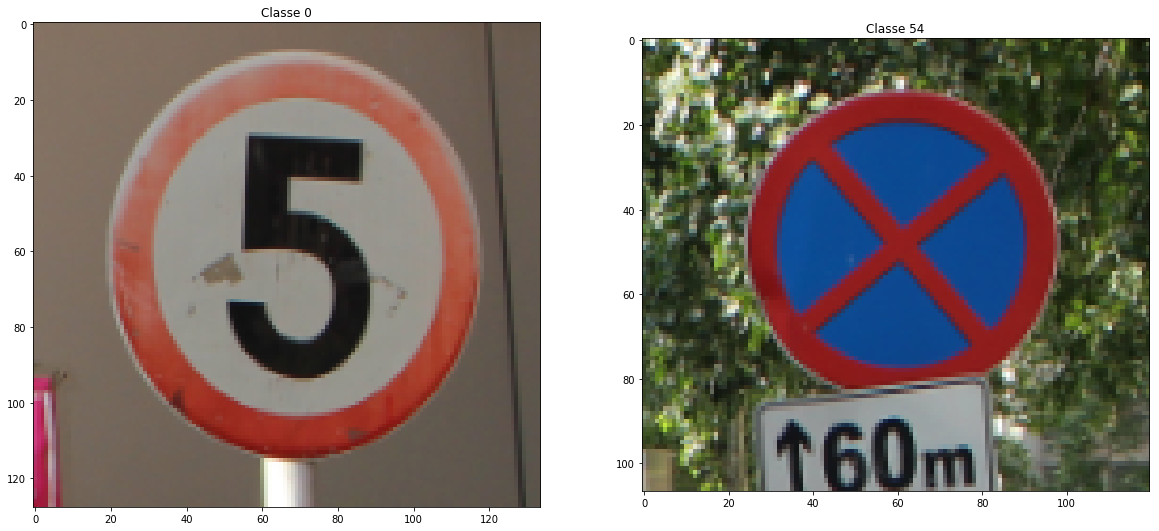

In [7]:
im1, im2 = 0, 3000

img1 = image_buffer[im1][:, :, [2,1,0]] 
img2 = image_buffer[im2][:, :, [2,1,0]] 

plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(img1)
plt.title("Classe {}".format(labels[im1]))
plt.subplot(122)
plt.imshow(img2)
plt.title("Classe {}".format(labels[im2]))

<h1>1. Première approche : </h1>

Pour cette première approche, on calcule les caractéristiques de l'image de la sorte:

<ol>
<li>Filtrer les couleurs d'intérêt (rouge, blanche, noire, bleue) </li>
<li>Calculer les histogrammes de gradients orientés</li>
</ol>

Les images seront ensuite classifiées à l'aide d'une forêt de décision aléatoire

In [8]:
def filter_color(frame):
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # Représentation HSV : teinte, saturation, lumière
    
    # Définition des bornes des 4 couleurs d'intérêt : white, black, red, blue
    
    boundaries = [
        (np.array([30, 150, 50]), np.array([255, 255, 180])),
        (np.array([17, 15, 100]), np.array([50, 56, 255])),
        (np.array([215, 245, 245]), np.array([255, 255, 255])),
        (np.array([0, 0, 0]), np.array([40, 10, 10]))
    ] 
    
    mask0 = cv2.inRange(hsv, boundaries[0][0], boundaries[0][1])
    mask1 = cv2.inRange(hsv, boundaries[1][0], boundaries[1][1])
    mask2 = cv2.inRange(hsv, boundaries[2][0], boundaries[2][1])
    mask3 = cv2.inRange(hsv, boundaries[3][0], boundaries[3][1])
    
    mask = (mask0 | mask1) | (mask2 | mask3)
    res = cv2.bitwise_and(frame,frame, mask= mask) # Application du masque
    
    return mask, res

def plot_all(frame, mask, res):
    plt.subplot(131)
    plt.imshow(frame[:,:,[2,1,0]])
    plt.title("frame")
    
    plt.subplot(132)
    plt.imshow(mask)
    plt.title("mask")
    
    plt.subplot(133)
    plt.imshow(res[:,:,[2,1,0]])
    plt.title("res")

### Visualisation de la fonction de filtrage

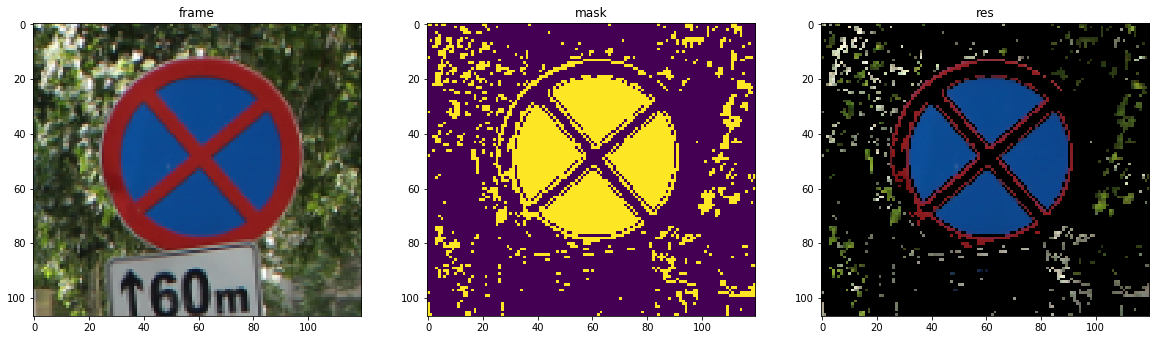

In [9]:
plt.figure(figsize=(20,10))
frame = image_buffer[3000]
mask, res = filter_color(frame)
plot_all(frame, mask, res)

### Calcul des représentations HOG (Histograms of Oriented Gradients)

In [10]:
def convert_my_pic(raw_image, resize=(64,64)):
    _, frame = filter_color(raw_image)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, resize)
    bins = 9
    cell_size = (8, 8)
    cpb = (2, 2)
    norm = "L2"
    features = ft.hog(img, orientations=bins, pixels_per_cell=cell_size, 
                        cells_per_block=cpb, block_norm=norm, transform_sqrt=True)
    return features

In [11]:
new_data = []
for i in range(len(image_buffer)):
    img = image_buffer[i][: ,: , :]
    feature = convert_my_pic(img)
    new_data.append(feature)

In [12]:
new_data = np.array(new_data)
labels = np.array(labels)

### Construction du jeu d'entrainement et de test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(new_data, labels, random_state = 42)

In [14]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (3127, 1764)
y_train shape :  (3127,)
X_test shape :  (1043, 1764)
y_test shape :  (1043,)


### Entrainement du classifieur : forêt aléatoire de 5000 arbres et une profondeur maximale de 10

In [15]:
classifier = RandomForestClassifier(n_estimators = 5000, n_jobs=-1, max_depth=10, random_state = 42)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

### Résultats de la premières approches

In [16]:
acc_train = 100*accuracy_score(y_train, y_train_pred)
acc_test = 100*accuracy_score(y_test, y_test_pred)

print("Training accuracy : {} % \nTest accuracy : {} %".format(round(acc_train, 2), round(acc_test, 2)))

Training accuracy : 89.54 % 
Test accuracy : 80.54 %


In [17]:
precision_test = precision_score(y_true = y_test, y_pred = y_test_pred, average = None)
recall_test = recall_score(y_true = y_test, y_pred = y_test_pred, average = None)
f1_test = f1_score(y_true = y_test, y_pred = y_test_pred, average = None)

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [18]:
precision_trace = go.Scatterpolar(
    r = precision_test, 
    theta = ["C{}".format(i) for i in range(len(precision_test))],
    name = "precision",
    fill = "toself"
)
recall_trace = go.Scatterpolar(
    r = recall_test, 
    theta = ["C{}".format(i) for i in range(len(recall_test))],
    fill = "toself",
    name = "recall"
)
f1_trace = go.Scatterpolar(
    r = f1_test, 
    theta = ["C{}".format(i) for i in range(len(f1_test))],
    name = "f1 score",
    fill = "toself",
)

traces = [precision_trace, recall_trace, f1_trace]

layout = go.Layout(title = "Performances par classe")

fig = go.Figure(data = traces, layout = layout)

iplot(fig)

In [19]:
report_train = classification_report(y_train, y_train_pred)
report_test = classification_report(y_test, y_test_pred)
print(report_train)
print(report_test)

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        81
          1       1.00      1.00      1.00        29
          2       1.00      0.80      0.89        61
          3       0.91      0.89      0.90       199
          4       1.00      0.76      0.86        67
          5       0.99      0.75      0.85       132
          6       1.00      0.98      0.99        57
          7       0.97      0.94      0.95       112
          8       1.00      1.00      1.00         7
          9       0.00      0.00      0.00         1
         10       1.00      1.00      1.00        54
         11       1.00      0.93      0.96        95
         12       1.00      0.82      0.90        78
         13       1.00      0.80      0.89        30
         14       1.00      0.85      0.92        93
         15       1.00      1.00      1.00        12
         16       1.00      0.97      0.99       106
         17       1.00      1.00      1.00   

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



<h2>Seconde approche : </h2>

Dans cette approche on calcule directement les caractéristiques HOG sans filtrage des couleurs d'intérêt

In [20]:
def hog_feature(img_array, resize=(64,64)):
    """extract hog feature from an image.
    Args:
        img_array: an image array.
        resize: size of the image for extracture.  
    Return:
    features:  a ndarray vector.      
    """
    img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, resize)
    bins = 9
    cell_size = (8, 8)
    cpb = (2, 2)
    norm = "L2"
    features = ft.hog(img, orientations=bins, pixels_per_cell=cell_size, 
                        cells_per_block=cpb, block_norm=norm, transform_sqrt=True)
    return features

In [21]:
new_data = []

for i in range(len(image_buffer)):
    img = image_buffer[i]
    feature = hog_feature(img)
    new_data.append(feature)    

In [22]:
new_data = np.array(new_data)

X_train, X_test, y_train, y_test = train_test_split(new_data, labels, random_state = 42)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (3127, 1764)
y_train shape :  (3127,)
X_test shape :  (1043, 1764)
y_test shape :  (1043,)


In [23]:
classifier2 = RandomForestClassifier(n_estimators = 5000, n_jobs=-1, max_depth=10, random_state = 42)
classifier2.fit(X_train, y_train)

y_train_pred = classifier2.predict(X_train)
y_test_pred = classifier2.predict(X_test)

In [24]:
acc_train = 100*accuracy_score(y_train, y_train_pred)
acc_test = 100*accuracy_score(y_test, y_test_pred)

print("Training accuracy : {} % \nTest accuracy : {} %".format(round(acc_train, 2), round(acc_test, 2)))

Training accuracy : 99.97 % 
Test accuracy : 98.95 %


In [25]:
precision_test = precision_score(y_true = y_test, y_pred = y_test_pred, average = None)
recall_test = recall_score(y_true = y_test, y_pred = y_test_pred, average = None)
f1_test = f1_score(y_true = y_test, y_pred = y_test_pred, average = None)

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [26]:
precision_trace = go.Scatterpolar(
    r = precision_test, 
    theta = ["C{}".format(i) for i in range(len(precision_test))],
    name = "precision",
    fill = "toself"
)
recall_trace = go.Scatterpolar(
    r = recall_test, 
    theta = ["C{}".format(i) for i in range(len(recall_test))],
    fill = "toself",
    name = "recall"
)
f1_trace = go.Scatterpolar(
    r = f1_test, 
    theta = ["C{}".format(i) for i in range(len(f1_test))],
    name = "f1 score",
    fill = "toself",
)

traces = [precision_trace, recall_trace, f1_trace]

layout = go.Layout(title = "Performances par classe")

fig = go.Figure(data = traces, layout = layout)

iplot(fig)

In [27]:
report_train = classification_report(y_train, y_train_pred)
report_test = classification_report(y_test, y_test_pred)
print(report_train)
print(report_test)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        81
          1       1.00      1.00      1.00        29
          2       1.00      1.00      1.00        61
          3       1.00      1.00      1.00       199
          4       1.00      1.00      1.00        67
          5       1.00      1.00      1.00       132
          6       1.00      1.00      1.00        57
          7       1.00      1.00      1.00       112
          8       1.00      1.00      1.00         7
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00        54
         11       1.00      1.00      1.00        95
         12       1.00      1.00      1.00        78
         13       1.00      1.00      1.00        30
         14       1.00      1.00      1.00        93
         15       1.00      1.00      1.00        12
         16       1.00      1.00      1.00       106
         17       1.00      1.00      1.00   

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

